<a href="https://colab.research.google.com/github/darthfelipe21/LangGraph/blob/main/LangGraphMultiAgentTools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

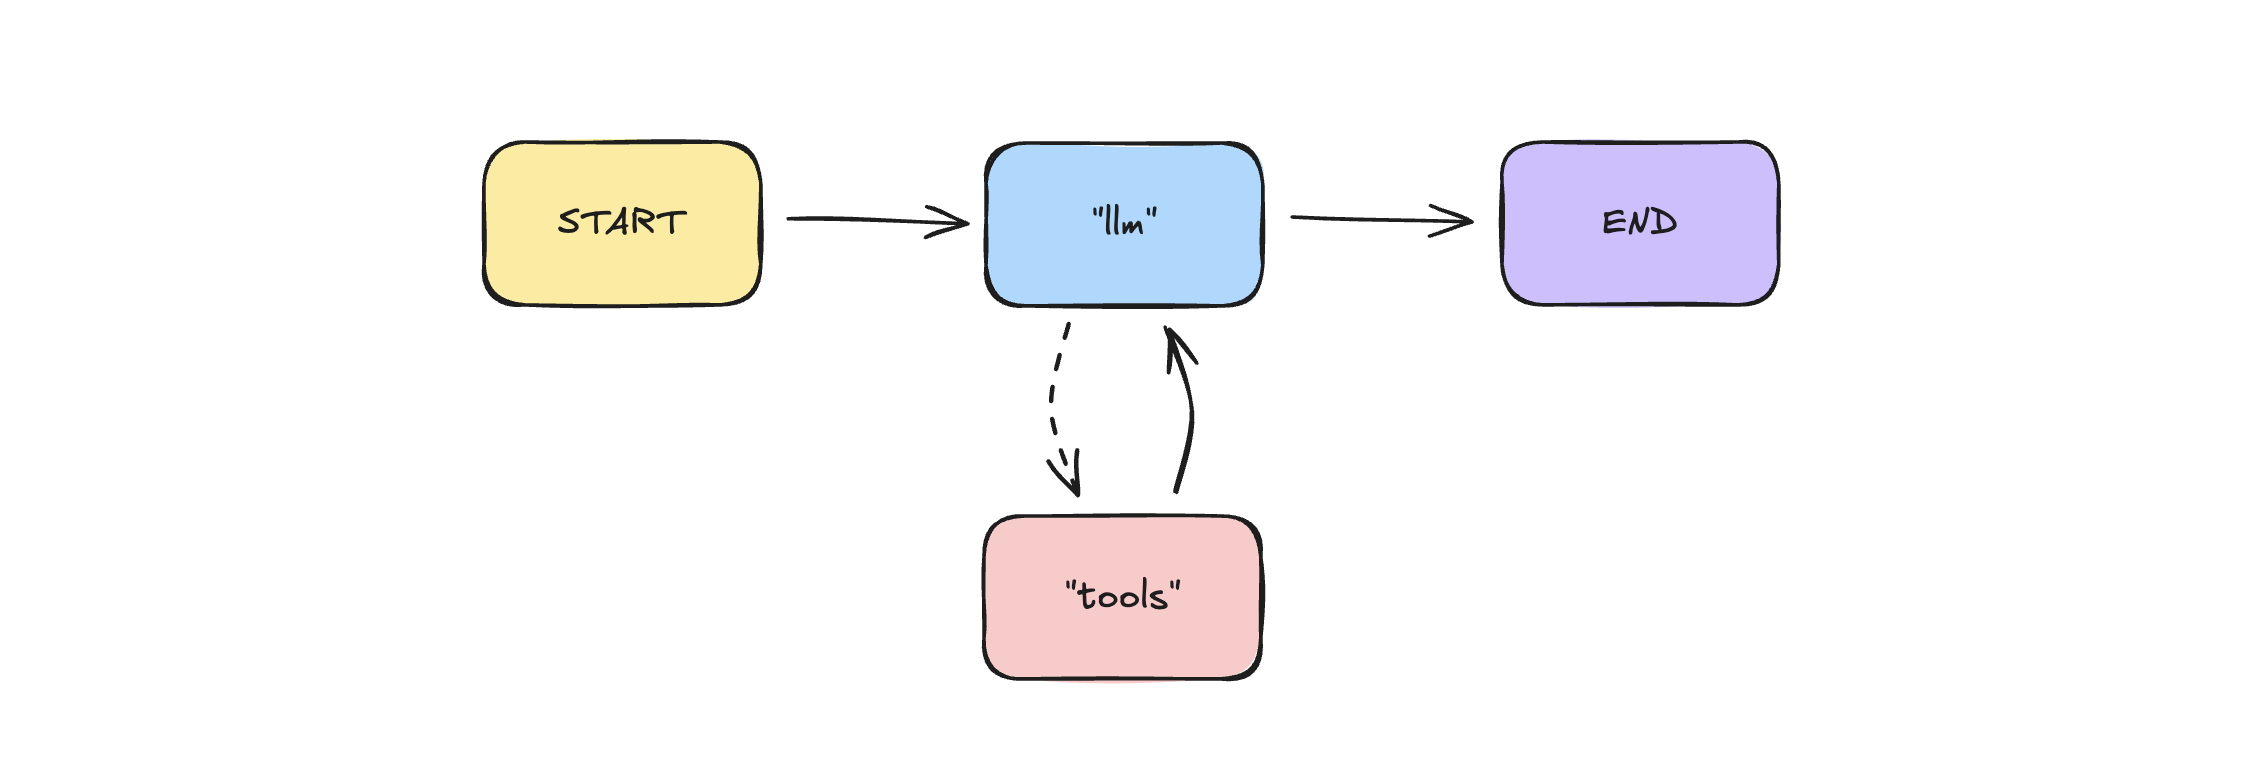

### 🪚 Making tools optional

In the last exercise, you saw how the linear workflow directed all LLM outputs into the tool node, irrespective of whether a tool call was required. Let's change this so our system can handle user inputs that don't require tool calls.

In [ ]:
!pip install --quiet wikipedia==1.4.0 langchain-core==0.3.59 langgraph==0.5.3 langchain-openai==0.3.16 langchain-experimental==0.3.4

In [ ]:
from typing import Annotated
import wikipedia
from langchain_core.tools import tool
import pandas as pd
import os

@tool
def wikipedia_tool(
    query: Annotated[str, "The Wikipedia search to execute to find key summary information."],
):
    """Use this to search Wikipedia for factual information."""
    try:
        # Step 1: Search using query
        results = wikipedia.search(query)

        if not results:
            return "No results found on Wikipedia."

        # Step 2: Retrieve page title
        title = results[0]

        # Step 3: Fetch summary
        summary = wikipedia.summary(title, sentences=8, auto_suggest=False, redirect=True)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\nWikipedia summary: {summary}"

@tool
def stock_data_tool(
    company_ticker: Annotated[str, "The ticker symbol of the company to retrieve their stock performance data."],
    num_days: Annotated[int, "The number of business days of stock data required to respond to the user query."]
) -> str:
    """
    Use this to look-up stock performance data for companies to retrieve a table from a CSV. You may need to convert company names into ticker symbols to call this function, e.g, Apple Inc. -> AAPL, and you may need to convert weeks, months, and years, into days.
    """

    # Load the CSV for the company requested
    file_path = f"data/{company_ticker}.csv"

    if os.path.exists(file_path) is False:
        return f"Sorry, but data for company {company_ticker} is not available. Please try Apple, Amazon, Meta, Microsoft, Netflix, or Tesla."

    stock_df = pd.read_csv(file_path, index_col='Date', parse_dates=True)

    # Ensure the index is in date format
    stock_df.index = stock_df.index.date

    # Maximum num_days supported by the dataset
    max_num_days = (stock_df.index.max() - stock_df.index.min()).days

    if num_days > max_num_days:
        return "Sorry, but this time period exceeds the data available. Please reduce it to continue."

    # Get the most recent date in the DataFrame
    final_date = stock_df.index.max()

    # Filter the DataFrame to get the last num_days of stock data
    filtered_df = stock_df[stock_df.index > (final_date - pd.Timedelta(days=num_days))]

    return f"Successfully executed the stock performance data retrieval tool to retrieve the last *{num_days} days* of data for company **{company_ticker}**:\n\n{filtered_df.to_markdown()}"

from langchain_experimental.utilities import PythonREPL

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user. The chart should be displayed using `plt.show()`."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed the Python REPL tool.\n\nPython code executed:\n\`\`\`python\n{code}\n\`\`\`\n\nCode output:\n\`\`\`\n{result}\`\`\`"

### ❓Introducing conditional edges

One of the problems with our current agentic system is that the chatbot node was always directed into the tools node, regardless of whether the user input requires the tools or not. This means that the LLM isn't really making a decision, as there is no other choice but to proceed.

LangGraph provides ***conditional edges***, which are like splits in the workflow where the agent can choose which way to go.

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Add three tools to the list: wikipedia_tool, stock_data_tool, and python_repl_tool
tools = [wikipedia_tool, stock_data_tool, python_repl_tool]

llm = ChatOpenAI(model="gpt-4o-mini")

# Tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def llm_node(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

### ➕ Adding the conditional edge

Now to build the graph! We need to build `"llm"` and `"tools"` nodes as before, but this time, you need to add a conditional edge to the `"llm"` node, so it can use the `tools_condition` function to decide whether to trigger the tools or end. `"tools"` must also be connected back to `"llm"` so the LLM can decide whether it is able to end the task or trigger another tool.

The `.add_conditional_edges()` method is similar to `.add_edge()`, taking a source node to start at, but then it takes a function to evaluate how to proceed, and a dictionary indicating which nodes to continue to, depending on the evaluation.

The following code uses the built-in `tools_condition`, which asks the model to decide if a tool is required; if so, it moves to the `"tools"` node, if not, it moves to the `END` node (which is named `__end__`).

```py
graph_builder.add_conditional_edges(START, tools_condition, {"tools", END})
```

In [ ]:
from langgraph.prebuilt import ToolNode, tools_condition

# Create the llm and tools nodes
graph_builder.add_node('llm', llm_node)
tool_node = ToolNode(tools=tools)
graph_builder.add_node('tools', tool_node)

# Add the edges
graph_builder.add_edge(START, 'llm')
graph_builder.add_conditional_edges('llm', tools_condition, ['tools', END])
graph_builder.add_edge('tools', 'llm')

graph = graph_builder.compile()

In [ ]:
# Visualize your graph
graph

Nicely done! The input is enters the chatbot node, which then decides whether a tool needs to be triggered. If it is required, the tools are called; if not, the chatbot responds using its knowledge and ends the interaction.

Try re-running the same inputs as before to spot the difference!

1. Tell me about Apple Inc.
2. AAPL stock price.
3. My name is `<Insert your name>`.
4. Plot an Open price time-series of AAPL.

In [ ]:
from course_helper_functions import pretty_print_messages

for chunk in graph.stream(
    {"messages": [{"role": "user", "content": "Tell me about Apple Inc."}]}
):
    pretty_print_messages(chunk)